# CS-483: Big Data Mining - Progress Report
# Interpreting Algorithmic Fairness via Aleatoric and Epistemic Uncertainties
##### By Zohair Hashmi | Sajal Chandra | Rayaan Siddiqi | Sean Kudrna

### Part 1 : Epistemic Uncertainty & Fairness Estimation

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf

from aif360.datasets import BinaryLabelDataset
from aif360.datasets import AdultDataset, GermanDataset, CompasDataset
from aif360.datasets import StructuredDataset
from aif360.metrics import BinaryLabelDatasetMetric
from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult, load_preproc_data_german

from IPython.display import Markdown, display

import keras
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.utils import to_categorical
from keras import regularizers
from keras.callbacks import EarlyStopping


import keras_uncertainty as ku
import keras_uncertainty.backend as K

from keras_uncertainty.layers import StochasticDropout
from keras_uncertainty.layers import DropConnectDense, VariationalDense, FlipoutDense, SamplingSoftmax
from keras_uncertainty.utils import numpy_entropy


`load_boston` has been removed from scikit-learn since version 1.2.

The Boston housing prices dataset has an ethical problem: as
investigated in [1], the authors of this dataset engineered a
non-invertible variable "B" assuming that racial self-segregation had a
positive impact on house prices [2]. Furthermore the goal of the
research that led to the creation of this dataset was to study the
impact of air quality but it did not give adequate demonstration of the
validity of this assumption.

The scikit-learn maintainers therefore strongly discourage the use of
this dataset unless the purpose of the code is to study and educate
about ethical issues in data science and machine learning.

In this special case, you can fetch the dataset from the original
source::

    import pandas as pd
    import numpy as np

    data_url = "http://lib.stat.cmu.edu/datasets/boston"
    raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
    data = np.hstack([raw_df.values[::2, :], raw_d

Keras Uncertainty will use standalone Keras backend

### LOADING DATASET FROM AIF360

Currently we are working with "Adult Dataset" in this notebook. The following code loads the dataset from AIF360. The dataset is already split into train and test sets. We will use the train set to train our models and the test set to evaluate the models.

In [ ]:
# load dataset
dataset_orig = load_preproc_data_adult()

# split into train and test
dataset_orig_train, dataset_orig_test = dataset_orig.split([0.80], shuffle=True)

# priveleged and unpriveleged groups
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

display(Markdown("#### Training Dataset shape"))
print(dataset_orig_train.features.shape)
display(Markdown("#### Test Dataset shape"))
print(dataset_orig_test.features.shape)
display(Markdown("#### Favorable and unfavorable labels"))
print(dataset_orig_train.favorable_label, dataset_orig_train.unfavorable_label)
display(Markdown("#### Protected attribute names"))
print(dataset_orig_train.protected_attribute_names)
display(Markdown("#### Privileged and unprivileged protected attribute values"))
print(dataset_orig_train.privileged_protected_attributes, dataset_orig_train.unprivileged_protected_attributes)
display(Markdown("#### Priveleged and unpriveleged groups"))
print(privileged_groups, unprivileged_groups)
display(Markdown("#### Dataset feature names"))
print(dataset_orig_train.feature_names)

#### Training Dataset shape

(39073, 18)


#### Test Dataset shape

(9769, 18)


#### Favorable and unfavorable labels

1.0 0.0


#### Protected attribute names

['sex', 'race']


#### Privileged and unprivileged protected attribute values

[array([1.]), array([1.])] [array([0.]), array([0.])]


#### Priveleged and unpriveleged groups

[{'sex': 1}] [{'sex': 0}]


#### Dataset feature names

['race', 'sex', 'Age (decade)=10', 'Age (decade)=20', 'Age (decade)=30', 'Age (decade)=40', 'Age (decade)=50', 'Age (decade)=60', 'Age (decade)=>=70', 'Education Years=6', 'Education Years=7', 'Education Years=8', 'Education Years=9', 'Education Years=10', 'Education Years=11', 'Education Years=12', 'Education Years=<6', 'Education Years=>12']


In [5]:
dataset_frac = np.round(np.linspace(0.1, 1.0, 10), 1)
dataset_frac

array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [4]:
# prepare all possible train sets with different pruning percentages 
# and store them in a dictionary
train_sets = {}
for frac in dataset_frac:
    train_sets[frac] = dataset_orig_train.copy(deepcopy=True)
    train_sets[frac] = train_sets[frac].split([frac], shuffle=True)[0]

#print shape of each train set
for frac in dataset_frac:
    print("{}% of the data set: ".format(frac*100), end=" ")
    print(train_sets[frac].features.shape)

NameError: name 'dataset_orig_train' is not defined

In [157]:
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]

In [9]:
#print the shape of each train group A
for i in range(10):
    print("Train group A features & labels shape for pruning percentage", dataset_frac[i]*100, ":\t", train_sets[dataset_frac[i]].features.shape, train_sets[dataset_frac[i]].labels.shape)
    

Train group A features & labels shape for pruning percentage 10.0 :	 (3907, 18) (3907, 1)
Train group A features & labels shape for pruning percentage 20.0 :	 (7814, 18) (7814, 1)
Train group A features & labels shape for pruning percentage 30.0 :	 (11721, 18) (11721, 1)
Train group A features & labels shape for pruning percentage 40.0 :	 (15629, 18) (15629, 1)
Train group A features & labels shape for pruning percentage 50.0 :	 (19536, 18) (19536, 1)
Train group A features & labels shape for pruning percentage 60.0 :	 (23443, 18) (23443, 1)
Train group A features & labels shape for pruning percentage 70.0 :	 (27351, 18) (27351, 1)
Train group A features & labels shape for pruning percentage 80.0 :	 (31258, 18) (31258, 1)
Train group A features & labels shape for pruning percentage 90.0 :	 (35165, 18) (35165, 1)
Train group A features & labels shape for pruning percentage 100.0 :	 (39073, 18) (39073, 1)


The above files are now stored as .pkl files in the directory. Use these files directly for running model tests.

In [8]:
# save train_sets to file
import pickle
with open('adult_results/adult_train_sets.pickle', 'wb') as handle:
    pickle.dump(train_sets, handle, protocol=pickle.HIGHEST_PROTOCOL)

# save test set to file
with open('adult_results/adult_test_set.pickle', 'wb') as handle:
    pickle.dump(dataset_orig_test, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

### Loading the dataset from the .pkl files

In [6]:
# load train sets from file
import pickle
with open('adult_results/adult_train_sets.pickle', 'rb') as handle:
    train_sets = pickle.load(handle)

# load test set from file
with open('adult_results/adult_test_set.pickle', 'rb') as handle:
    dataset_orig_test = pickle.load(handle)

### MODEL DEFINITIONS

In [10]:
class StochasticModel:
    """
        Stochastic model, requiring several forward passes to produce an estimate of the posterior predictive distribution.
        This class just wraps a keras model to enable dropout at inference time.
    """
    def __init__(self, model, num_samples=10):
        """
            Builds a stochastic model from a keras model. The model should already be trained.
        """
        self.model = model
        self.num_samples = num_samples
    
    def predict_samples(self, x, num_samples=None, batch_size=1, multi_output=False, **kwargs):
        """
            Performs num_samples predictions using the model, and returns the produced output samples.
        """

        if num_samples is None:
            num_samples = self.num_samples

        assert num_samples > 0
        samples = [None] * num_samples

        if "verbose" not in kwargs:
            kwargs["verbose"] = 0

        for i in range(num_samples):
            samples[i] = self.model.predict(x, batch_size=batch_size, **kwargs)

        if multi_output:
            return samples
        else:
            return np.array(samples)

class StochasticClassifier(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, **kwargs):
        """
            Performs a prediction given input inp using MC Dropout, and returns the averaged probabilities of model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)
        mean_probs = np.mean(samples, axis=0)
        mean_probs = mean_probs / np.sum(mean_probs, axis=1, keepdims=True)

        return mean_probs

class  StochasticRegressor(StochasticModel):
    def __init__(self, model, num_samples=10):
        super().__init__(model, num_samples)

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, **kwargs):
        """
            Performs a prediction  given input inp using MC Dropout, and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, **kwargs)

        if output_scaler is not None:
            samples = list(map(lambda x: output_scaler.inverse_transform(x), samples))

        mean_pred = np.mean(samples, axis=0)
        std_pred = np.std(samples, axis=0)

        return mean_pred, std_pred    

class TwoHeadStochasticRegressor(StochasticModel):
    """
        A stochastic model that has two ouput heads, one for mean and another for variance, useful for aleatoric/epistemic uncertainty estimation.
    """
    def __init__(self, model, num_samples=10, variance_type="linear_variance"):
        super().__init__(model, num_samples)

        assert variance_type in ["logit", "linear_std", "linear_variance"]
        self.variance_type = variance_type

    """
        Preprocesses and interprets the variance output prodcued by the model, producing a standard deviation.
    """
    def preprocess_variance_output(self, var_input):
        if self.variance_type is "logit":
            return np.exp(var_input)

        if self.variance_type is "linear_variance":
            return np.sqrt(var_input)
        
        return var_input

    def predict(self, inp, num_samples=None, batch_size=32, output_scaler=None, disentangle_uncertainty=False, **kwargs):
        """
            Performs a prediction given input inp and returns the mean and standard deviation of the model output.
        """
        samples = self.predict_samples(inp, num_samples, batch_size=batch_size, multi_output=True, **kwargs)
        mean_samples, var_samples = [x[0] for x in samples], [x[1] for x in samples]

        if output_scaler is not None:
            mean_samples = list(map(lambda x: output_scaler.inverse_transform(x), mean_samples))
            var_samples = list(map(lambda x: output_scaler.inverse_transform(x), var_samples))

        means = np.array(mean_samples)
        variances = np.array(var_samples)
        stds = self.preprocess_variance_output(variances)
        
        mixture_mean = np.mean(means, axis=0)
        mixture_var  = np.mean(np.square(stds) + np.square(means), axis=0) - np.square(mixture_mean)
        mixture_var[mixture_var < 0.0] = 0.0
        mixture_std = np.sqrt(mixture_var)
                                
        if disentangle_uncertainty:            
            epi_std = np.std(means, axis=0)
            ale_std = np.mean(stds, axis=0)

            return mixture_mean, ale_std, epi_std

        return mixture_mean, mixture_std

class KernelDensityStochasticModel(StochasticModel):
    def __init__(self, model, num_samples=10, bandwidth=1.0):
        super().__init__(model, num_samples)

def softmax(x, axis=-1):
    x = x - np.max(x, axis=axis, keepdims=True)

    return np.exp(x) / np.sum(np.exp(x), axis=axis, keepdims=True)

def sampling_softmax(mean_logit, std_logit, num_samples=10):
    logit_shape = (mean_logit.shape[0], num_samples, mean_logit.shape[-1])

    logit_mean = np.expand_dims(mean_logit, axis=1)
    logit_mean = np.repeat(logit_mean, num_samples, axis=1)

    logit_std = np.expand_dims(std_logit, axis=1)
    logit_std = np.repeat(logit_std, num_samples, axis=1)

    logit_samples = np.random.normal(size=logit_shape, loc=logit_mean, scale=logit_std)

    prob_samples = softmax(logit_samples, axis=-1)
    probs = np.mean(prob_samples, axis=1)

    # This is required due to approximation error, without it probabilities can sum to 1.01 or 0.99
    probs = probs / np.sum(probs, axis=-1, keepdims=True) 

    return probs

class DisentangledStochasticClassifier(TwoHeadStochasticRegressor):
    def __init__(self, model, epi_num_samples=10, ale_num_samples=100) -> None:
        super(DisentangledStochasticClassifier, self).__init__(model, num_samples=epi_num_samples)

        self.epi_num_samples = epi_num_samples
        self.ale_num_samples = ale_num_samples

    def predict(self, inp, num_samples=None, batch_size=32):
        y_logits_mean, y_logits_std_ale, y_logits_std_epi = TwoHeadStochasticRegressor.predict(self, inp, num_samples=num_samples, batch_size=batch_size, disentangle_uncertainty=True)

        y_probs = sampling_softmax(y_logits_mean, y_logits_std_ale + y_logits_std_epi, num_samples=self.ale_num_samples)
        y_probs_epi = sampling_softmax(y_logits_mean, y_logits_std_epi, num_samples=self.ale_num_samples)
        y_probs_ale = sampling_softmax(y_logits_mean, y_logits_std_ale, num_samples=self.ale_num_samples)

        return y_probs, y_probs_ale, y_probs_epi



<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\Zohair Hashmi\AppData\Local\Temp\ipykernel_1144\1140481961.py:81: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.variance_type is "logit":
C:\Users\Zohair Hashmi\AppData\Local\Temp\ipykernel_1144\1140481961.py:84: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if self.variance_type is "linear_variance":


In [147]:
def uncertainty(probs):
    return numpy_entropy(probs, axis=-1)

def two_head_model(trunk_model, num_classes=2, num_samples=100):
    inp = Input(shape=(18,))
    x = trunk_model(inp)
    logit_mean = Dense(num_classes, activation="linear")(x)
    logit_var = Dense(num_classes, activation="softplus")(x)
    probs = SamplingSoftmax(num_samples=num_samples, variance_type="linear_std")([logit_mean, logit_var])
    
    train_model = Model(inp, probs, name="train_model")
    pred_model = Model(inp, [logit_mean, logit_var], name="pred_model")

    train_model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    
    return train_model, pred_model

def train_eval_stochastic_model(trunk_model, x_train, y_train, domain, epochs=300):
    train_model, pred_model = two_head_model(trunk_model)
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    train_model.fit(x_train, y_train, verbose=2, epochs=epochs, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[es])

    fin_model = DisentangledStochasticClassifier(pred_model, epi_num_samples=NUM_SAMPLES)
    print("predicting...")
    pred_mean, pred_ale_std, pred_epi_std = fin_model.predict(domain, batch_size=BATCH_SIZE)
    print("prediction completed")
    ale_entropy = uncertainty(pred_ale_std)
    epi_entropy = uncertainty(pred_epi_std)

    return pred_mean, ale_entropy, epi_entropy

def train_dropout_model(x_train, y_train, domain, prob=0.5):
    model = Sequential()
    model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
    model.add(StochasticDropout(prob))
    model.add(Dense(32, activation="relu"))
    model.add(StochasticDropout(prob))

    model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

    return train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)

def train_ensemble_model(x_train, y_train, domain, ensemble_size=10):
    models = []
    for i in range(ensemble_size):
        model = Sequential()
        model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
        model.add(Dense(32, activation="relu", kernel_regularizer=regularizers.l2(0.1)))
        model.add(Dense(2, activation="linear"))

        model.compile(loss=tf.keras.losses.BinaryCrossentropy(),
                      optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                      metrics=[tf.keras.metrics.BinaryAccuracy(),
                               tf.keras.metrics.FalseNegatives()])

        models.append(model)

    ale_entropy = 0
    epi_entropy = 0
    pred = []
    i = 0

    for model in models:
        pred_prob, ale, epi = train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)
        ale_entropy += ale
        epi_entropy += epi
        pred.append(pred_prob)
        print('ensemble model ', i + 1, ' trained')
        i += 1

    ale_entropy /= ensemble_size
    epi_entropy /= ensemble_size
    # average the prediction
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)
    return pred, ale_entropy, epi_entropy

def train_dropout_ensemble_model(x_train, y_train, domain, prob=0.5, ensemble_size=10):
    models = []
    for i in range(ensemble_size):
        model = Sequential()
        model.add(Dense(32, activation="relu", input_shape=(x_train.shape[1],)))
        model.add(StochasticDropout(prob))
        model.add(Dense(32, activation="relu"))
        model.add(StochasticDropout(prob))

        model.compile(loss="sparse_categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

        models.append(model)

    ale_entropy = 0
    epi_entropy = 0
    pred = []
    i = 0

    for model in models:
        pred_prob, ale, epi = train_eval_stochastic_model(model, x_train, y_train, domain, epochs=100)
        ale_entropy += ale
        epi_entropy += epi
        pred.append(pred_prob)
        print('ensemble model ', i + 1, ' trained')
        i += 1

    ale_entropy /= ensemble_size
    epi_entropy /= ensemble_size
    pred = np.array(pred)
    pred = np.mean(pred, axis=0)

    return pred, ale_entropy, epi_entropy
        
NUM_SAMPLES = 50
BATCH_SIZE = 256

### FAIRNESS METRICS - EQUALITY OF OPPORTUNITY

In [132]:
# function to assign prediction based on threshold
def assign_pred(pred_prob, class_threshold):
    predicted_labels = []
    for i in range(len(pred_prob)):
        predictions = []
        for x in pred_prob[i][:,0]:
            if x > class_threshold:
                predictions.append(0.0)
            else:
                predictions.append(1.0)
        predicted_labels.append(predictions)

    return predicted_labels

#function for equal opportunity difference for each threshold
def equal_opportunity_difference(dataset_orig_test, pred_prob, class_threshold):
    predicted_labels = assign_pred(pred_prob, class_threshold)
    df_test = dataset_orig_test.convert_to_dataframe()[0]
    equal_opportunity_difference = []
    for i in range(0, len(predicted_labels)):
        df_test['Income Binary'] = predicted_labels[i]

        structured_dataset = StructuredDataset(df_test, dataset_orig_test.label_names, dataset_orig_test.protected_attribute_names)

        structured_binary_dataset = BinaryLabelDataset(df=structured_dataset.convert_to_dataframe()[0], 
                                         label_names=dataset_orig_test.label_names, 
                                         protected_attribute_names=dataset_orig_test.protected_attribute_names, 
                                         favorable_label=dataset_orig_test.favorable_label, 
                                         unfavorable_label=dataset_orig_test.unfavorable_label)
        
        classified_metric = ClassificationMetric(dataset_orig_test, 
                                                 structured_binary_dataset,
                                                 unprivileged_groups=unprivileged_groups,
                                                 privileged_groups=privileged_groups)
        
        equal_opportunity_difference.append(abs(classified_metric.equal_opportunity_difference()))
        print("Equal opportunity difference for dataset of size %.2f = %f" % (i*0.1+0.1, abs(classified_metric.equal_opportunity_difference())))
            #    = %f" % abs(classified_metric.equal_opportunity_difference()))

    return equal_opportunity_difference

In [12]:
import tensorflow as tf
print('GPU name: ', tf.config.experimental.list_physical_devices('GPU'))

GPU name:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


### ENSEMBLE MODEL

In [139]:
# train ensemble model for dataset size 0.1 to 1.0
ale_entropy_ensemble = []
epi_entropy_ensemble = []
pred_prob_ensemble = []

for i in range(0, 10):
    print('dataset size: ', np.round((i * 0.1 + 0.1),1))
    pred, ale_entropy, epi_entropy = train_ensemble_model(train_sets[dataset_frac[i]].features, train_sets[dataset_frac[i]].labels.ravel(), dataset_orig_test.features, ensemble_size=10)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_ensemble.append(ale_entropy)
    epi_entropy_ensemble.append(epi_entropy)
    pred_prob_ensemble.append(pred)

    print('')

dataset size:  0.1
Epoch 1/100
13/13 - 13s - loss: 3.7778 - accuracy: 0.6250 - val_loss: 3.5352 - val_accuracy: 0.7238 - 13s/epoch - 994ms/step
Epoch 2/100
13/13 - 0s - loss: 3.3568 - accuracy: 0.7552 - val_loss: 3.1430 - val_accuracy: 0.7545 - 283ms/epoch - 22ms/step
Epoch 3/100
13/13 - 0s - loss: 2.9888 - accuracy: 0.7638 - val_loss: 2.8027 - val_accuracy: 0.7558 - 211ms/epoch - 16ms/step
Epoch 4/100
13/13 - 0s - loss: 2.6667 - accuracy: 0.7638 - val_loss: 2.5035 - val_accuracy: 0.7558 - 125ms/epoch - 10ms/step
Epoch 5/100
13/13 - 0s - loss: 2.3842 - accuracy: 0.7638 - val_loss: 2.2435 - val_accuracy: 0.7558 - 148ms/epoch - 11ms/step
Epoch 6/100
13/13 - 0s - loss: 2.1357 - accuracy: 0.7638 - val_loss: 2.0127 - val_accuracy: 0.7558 - 128ms/epoch - 10ms/step
Epoch 7/100
13/13 - 0s - loss: 1.9161 - accuracy: 0.7638 - val_loss: 1.8084 - val_accuracy: 0.7558 - 186ms/epoch - 14ms/step
Epoch 8/100
13/13 - 0s - loss: 1.7231 - accuracy: 0.7638 - val_loss: 1.6258 - val_accuracy: 0.7558 - 133ms

In [140]:
Equal_opp_diffs_ensemble = equal_opportunity_difference(dataset_orig_test, pred_prob_ensemble, 0.5)

Equal opportunity difference for dataset of size 0.10 = 0.449348
Equal opportunity difference for dataset of size 0.20 = 0.454865
Equal opportunity difference for dataset of size 0.30 = 0.448847
Equal opportunity difference for dataset of size 0.40 = 0.448345
Equal opportunity difference for dataset of size 0.50 = 0.450351
Equal opportunity difference for dataset of size 0.60 = 0.497994
Equal opportunity difference for dataset of size 0.70 = 0.459378
Equal opportunity difference for dataset of size 0.80 = 0.455868
Equal opportunity difference for dataset of size 0.90 = 0.445838
Equal opportunity difference for dataset of size 1.00 = 0.459378


In [141]:
#mean of each entropy in epi_entropy_ensemble
for i in range(0, 10):
    print('dataset size: ', np.round((i * 0.1 + 0.1),1))
    print('ale entropy: ', np.mean(ale_entropy_ensemble[i]))
    print('epi entropy: ', np.mean(epi_entropy_ensemble[i]))
    print('')


dataset size:  0.1
ale entropy:  0.4406959585333589
epi entropy:  0.412198451034542

dataset size:  0.2
ale entropy:  0.4410759826015914
epi entropy:  0.4158793373031786

dataset size:  0.3
ale entropy:  0.4365954841937596
epi entropy:  0.41067587444711534

dataset size:  0.4
ale entropy:  0.43761980942708745
epi entropy:  0.41189464333236436

dataset size:  0.5
ale entropy:  0.45362373209834017
epi entropy:  0.4280003503733929

dataset size:  0.6
ale entropy:  0.44274364391730997
epi entropy:  0.4185807097705979

dataset size:  0.7
ale entropy:  0.4335625447171057
epi entropy:  0.41136076525460186

dataset size:  0.8
ale entropy:  0.4398371985478691
epi entropy:  0.420116217913827

dataset size:  0.9
ale entropy:  0.43070281041683317
epi entropy:  0.41019925791424244

dataset size:  1.0
ale entropy:  0.43234153019020116
epi entropy:  0.41379853230391017



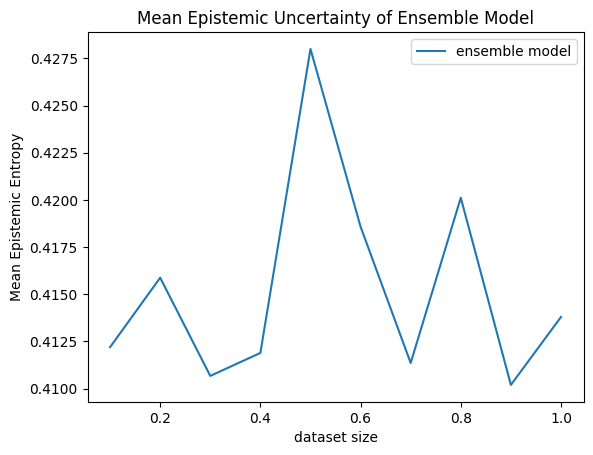

In [142]:
import matplotlib.pyplot as plt

# sketch graph for mean epistemic entropy of ensemble model
plt.plot(dataset_frac, np.mean(epi_entropy_ensemble, axis=1), label='ensemble model')
plt.xlabel('dataset size') # dataset size
plt.ylabel('Mean Epistemic Entropy')
plt.title('Mean Epistemic Uncertainty of Ensemble Model')
plt.legend()
plt.show()

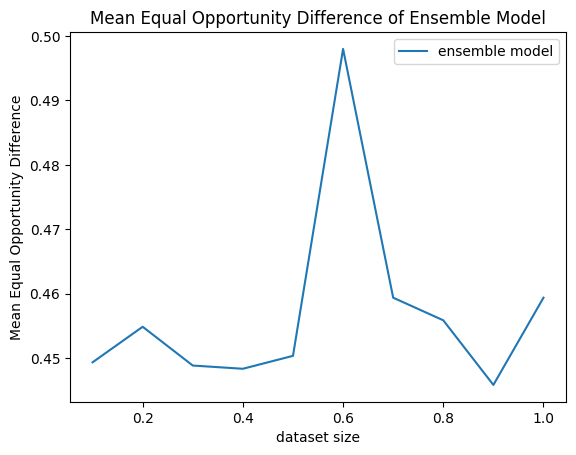

In [143]:
# sketch graph of mean equal opportunity difference for ensemble model
plt.plot(dataset_frac, Equal_opp_diffs_ensemble, label='ensemble model')
plt.xlabel('dataset size') # dataset size
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference of Ensemble Model')
plt.legend()
plt.show()


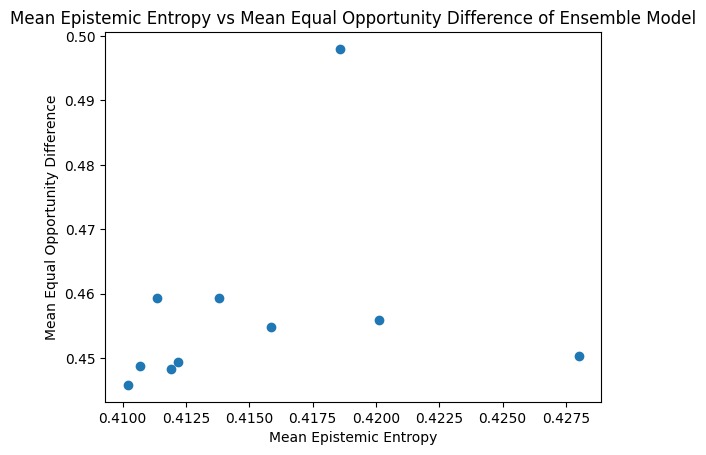

In [145]:
# plot epistemic entropy as x-axis and equal opportunity difference as y-axis for ensemble model
plt.scatter(np.mean(epi_entropy_ensemble, axis=1), Equal_opp_diffs_ensemble)
plt.xlabel('Mean Epistemic Entropy')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Epistemic Entropy vs Mean Equal Opportunity Difference of Ensemble Model')
plt.show()


In [146]:
#ale_entropy_ensemble to dict
ale_entropy_ensemble_dict = {}
for i in range(0, 10):
    ale_entropy_ensemble_dict[dataset_frac[i]] = ale_entropy_ensemble[i]
    
#epi_entropy_ensemble to dict
epi_entropy_ensemble_dict = {}
for i in range(0, 10):
    epi_entropy_ensemble_dict[dataset_frac[i]] = epi_entropy_ensemble[i]

#save to pickle file
import pickle

with open('adult_results/ale_entropy_ensemble_dict.pickle', 'wb') as handle:
    pickle.dump(ale_entropy_ensemble_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results/epi_entropy_ensemble_dict.pickle', 'wb') as handle:
    pickle.dump(epi_entropy_ensemble_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results/Equal_opp_diffs_ensemble.pickle', 'wb') as handle:
    pickle.dump(Equal_opp_diffs_ensemble, handle, protocol=pickle.HIGHEST_PROTOCOL)
    

### DROP OUT MODEL

In [14]:
# train dropout model for dataset size 0.1 to 1.0
ale_entropy_dropout = []
epi_entropy_dropout = []
pred_prob = []

for i in range(0, 10):
    print('dataset size: ', np.round((i * 0.1 + 0.1),1))
    pred, ale_entropy, epi_entropy = train_dropout_model(train_sets[dataset_frac[i]].features, train_sets[dataset_frac[i]].labels.ravel(), dataset_orig_test.features, prob=0.5)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    pred_prob.append(pred)
    ale_entropy_dropout.append(ale_entropy)
    epi_entropy_dropout.append(epi_entropy)

    print('')

dataset size:  0.1


C:\Users\ZOHAIR~1\AppData\Local\Temp\__autograph_generated_filecl8ut8_0.py:54: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(self).variance_type is 'linear_variance', if_body, else_body, get_state, set_state, ('do_return', 'retval_'), 2)
C:\Users\ZOHAIR~1\AppData\Local\Temp\__autograph_generated_filecl8ut8_0.py:55: SyntaxWarning: "is" with a literal. Did you mean "=="?
  ag__.if_stmt(ag__.ld(self).variance_type is 'logit', if_body_1, else_body_1, get_state_1, set_state_1, ('do_return', 'retval_'), 2)


Epoch 1/100
13/13 - 19s - loss: 0.6836 - accuracy: 0.5510 - val_loss: 0.6503 - val_accuracy: 0.6253 - 19s/epoch - 1s/step
Epoch 2/100
13/13 - 0s - loss: 0.6232 - accuracy: 0.6925 - val_loss: 0.5892 - val_accuracy: 0.7417 - 459ms/epoch - 35ms/step
Epoch 3/100
13/13 - 1s - loss: 0.5886 - accuracy: 0.7418 - val_loss: 0.5738 - val_accuracy: 0.7481 - 563ms/epoch - 43ms/step
Epoch 4/100
13/13 - 0s - loss: 0.5714 - accuracy: 0.7558 - val_loss: 0.5482 - val_accuracy: 0.7506 - 280ms/epoch - 22ms/step
Epoch 5/100
13/13 - 0s - loss: 0.5520 - accuracy: 0.7613 - val_loss: 0.5545 - val_accuracy: 0.7558 - 187ms/epoch - 14ms/step
Epoch 6/100
13/13 - 0s - loss: 0.5417 - accuracy: 0.7616 - val_loss: 0.5367 - val_accuracy: 0.7519 - 207ms/epoch - 16ms/step
Epoch 7/100
13/13 - 0s - loss: 0.5292 - accuracy: 0.7638 - val_loss: 0.5163 - val_accuracy: 0.7519 - 196ms/epoch - 15ms/step
Epoch 8/100
13/13 - 0s - loss: 0.5213 - accuracy: 0.7626 - val_loss: 0.5331 - val_accuracy: 0.7558 - 201ms/epoch - 15ms/step
Epo

In [137]:
Equal_opp_diffs_dropout = equal_opportunity_difference(dataset_orig_test, pred_prob, 0.5)

Equal opportunity difference for dataset of size 0.10 = 0.271314
Equal opportunity difference for dataset of size 0.20 = 0.444750
Equal opportunity difference for dataset of size 0.30 = 0.483952
Equal opportunity difference for dataset of size 0.40 = 0.470453
Equal opportunity difference for dataset of size 0.50 = 0.484955
Equal opportunity difference for dataset of size 0.60 = 0.466441
Equal opportunity difference for dataset of size 0.70 = 0.473420
Equal opportunity difference for dataset of size 0.80 = 0.473795
Equal opportunity difference for dataset of size 0.90 = 0.478435
Equal opportunity difference for dataset of size 1.00 = 0.467402


In [136]:
#mean of each entropy in ale and epi_entropy_dropout
for i in range(0, 10):
    print('dataset size: ', np.round((i * 0.1 + 0.1),1))
    print('ale entropy: ', np.mean(ale_entropy_dropout[i]))
    print('epi entropy: ', np.mean(epi_entropy_dropout[i]))
    print('')
    

dataset size:  0.1
ale entropy:  0.455959305852733
epi entropy:  0.471214965836654

dataset size:  0.2
ale entropy:  0.4005118098994138
epi entropy:  0.3788619388901892

dataset size:  0.3
ale entropy:  0.36696283066095975
epi entropy:  0.33401131145808877

dataset size:  0.4
ale entropy:  0.3856984846129245
epi entropy:  0.37521895978154945

dataset size:  0.5
ale entropy:  0.3838133554819818
epi entropy:  0.3778529557886042

dataset size:  0.6
ale entropy:  0.39351933899372427
epi entropy:  0.3789817402517221

dataset size:  0.7
ale entropy:  0.3818363881637925
epi entropy:  0.35891444396540834

dataset size:  0.8
ale entropy:  0.38552789334494914
epi entropy:  0.3672160027990948

dataset size:  0.9
ale entropy:  0.3926533410461557
epi entropy:  0.37095153611735643

dataset size:  1.0
ale entropy:  0.39177567559698473
epi entropy:  0.3526230720138184



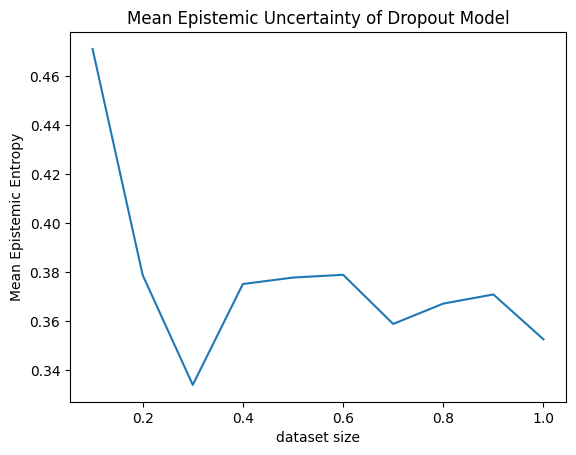

In [116]:
import matplotlib.pyplot as plt

#sketch graph of mean epistemic entropy for dropout model
plt.plot(dataset_frac, [np.mean(epi_entropy_dropout[i]) for i in range(0, 10)])
plt.xlabel('dataset size')
plt.ylabel('Mean Epistemic Entropy')
plt.title('Mean Epistemic Uncertainty of Dropout Model')
plt.show()



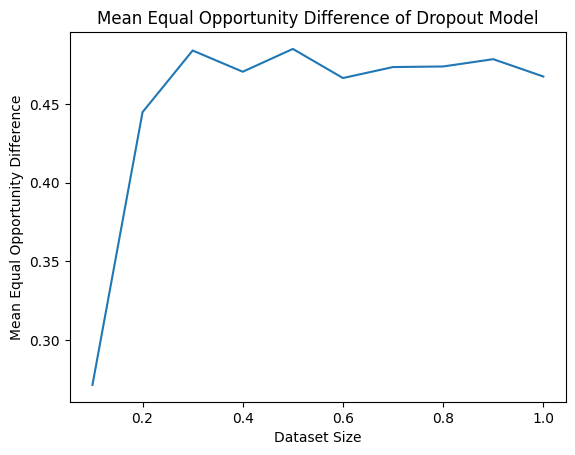

In [119]:
# sketch graph of mean equal opportunity difference for dropout model
plt.plot(dataset_frac, Equal_opp_diffs_dropout)
plt.xlabel('Dataset Size')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference of Dropout Model')
plt.show()



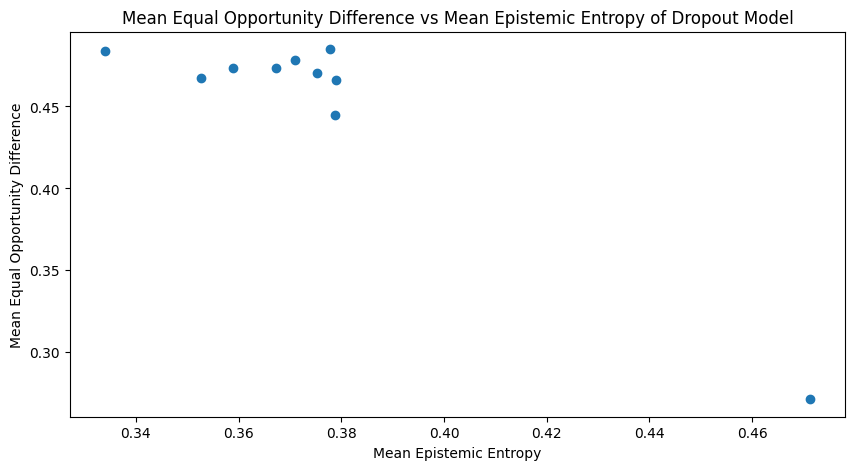

In [156]:
# plot epistemic entropy as x-axis and equal opportunity difference as y-axis for dropout model
plt.figure(figsize=(10, 5))
plt.scatter([np.mean(epi_entropy_dropout[i]) for i in range(0, 10)], Equal_opp_diffs_dropout)
plt.xlabel('Mean Epistemic Entropy')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference vs Mean Epistemic Entropy of Dropout Model')
plt.show()


In [112]:
#ale_entropy_dropout to dict
ale_entropy_dropout_dict = {}
for i in range(0, 10):
    ale_entropy_dropout_dict[dataset_frac[i]] = ale_entropy_dropout[i]

#epi_entropy_dropout to dict
epi_entropy_dropout_dict = {}
for i in range(0, 10):
    epi_entropy_dropout_dict[dataset_frac[i]] = epi_entropy_dropout[i]
    
#save to pickle file
import pickle

with open('adult_results/ale_entropy_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(ale_entropy_dropout_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results/epi_entropy_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(epi_entropy_dropout_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results/Equal_opp_diffs_dropout.pickle', 'wb') as handle:
    pickle.dump(Equal_opp_diffs_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)



### ENSEMBLE DROP OUT MODEL

In [149]:
# train ensemble dropout model for dataset size 0.1 to 1.0
ale_entropy_ensemble_dropout = []
epi_entropy_ensemble_dropout = []
pred_prob_ensemble_dropout = []

for i in range(0, 10):
    print('dataset size: ', np.round((i * 0.1 + 0.1),1))
    pred, ale_entropy, epi_entropy = train_dropout_ensemble_model(train_sets[dataset_frac[i]].features, train_sets[dataset_frac[i]].labels.ravel(), dataset_orig_test.features, ensemble_size=10, prob=0.5)
    print('ale entropy: ', np.mean(ale_entropy))
    print('epi entropy: ', np.mean(epi_entropy))

    # save ale and epi entropy
    ale_entropy_ensemble_dropout.append(ale_entropy)
    epi_entropy_ensemble_dropout.append(epi_entropy)
    pred_prob_ensemble_dropout.append(pred)

    print('')

dataset size:  0.1
Epoch 1/100
13/13 - 2s - loss: 0.6819 - accuracy: 0.5626 - val_loss: 0.6392 - val_accuracy: 0.6445 - 2s/epoch - 187ms/step
Epoch 2/100
13/13 - 0s - loss: 0.6185 - accuracy: 0.6973 - val_loss: 0.5978 - val_accuracy: 0.7136 - 138ms/epoch - 11ms/step
Epoch 3/100
13/13 - 0s - loss: 0.5831 - accuracy: 0.7405 - val_loss: 0.5738 - val_accuracy: 0.7468 - 144ms/epoch - 11ms/step
Epoch 4/100
13/13 - 0s - loss: 0.5633 - accuracy: 0.7555 - val_loss: 0.5565 - val_accuracy: 0.7468 - 136ms/epoch - 10ms/step
Epoch 5/100
13/13 - 0s - loss: 0.5571 - accuracy: 0.7568 - val_loss: 0.5295 - val_accuracy: 0.7583 - 139ms/epoch - 11ms/step
Epoch 6/100
13/13 - 0s - loss: 0.5364 - accuracy: 0.7651 - val_loss: 0.5197 - val_accuracy: 0.7583 - 202ms/epoch - 16ms/step
Epoch 7/100
13/13 - 0s - loss: 0.5168 - accuracy: 0.7632 - val_loss: 0.5218 - val_accuracy: 0.7481 - 134ms/epoch - 10ms/step
Epoch 8/100
13/13 - 0s - loss: 0.5099 - accuracy: 0.7658 - val_loss: 0.5012 - val_accuracy: 0.7532 - 169ms/e

In [150]:
Equal_opp_diffs_ensemble_dropout = equal_opportunity_difference(dataset_orig_test, pred_prob_ensemble_dropout, 0.5)

Equal opportunity difference for dataset of size 0.10 = 0.436810
Equal opportunity difference for dataset of size 0.20 = 0.471916
Equal opportunity difference for dataset of size 0.30 = 0.499498
Equal opportunity difference for dataset of size 0.40 = 0.490973
Equal opportunity difference for dataset of size 0.50 = 0.498495
Equal opportunity difference for dataset of size 0.60 = 0.504012
Equal opportunity difference for dataset of size 0.70 = 0.473420
Equal opportunity difference for dataset of size 0.80 = 0.483952
Equal opportunity difference for dataset of size 0.90 = 0.483952
Equal opportunity difference for dataset of size 1.00 = 0.474423


In [151]:
#mean of each entropy in ale and epi_entropy_ensemble_dropout
for i in range(0, 10):
    print('dataset size: ', np.round((i * 0.1 + 0.1),1))
    print('ale entropy: ', np.mean(ale_entropy_ensemble_dropout[i]))
    print('epi entropy: ', np.mean(epi_entropy_ensemble_dropout[i]))
    print('')

dataset size:  0.1
ale entropy:  0.4372722935317099
epi entropy:  0.4299152274922801

dataset size:  0.2
ale entropy:  0.4087815525819864
epi entropy:  0.3970674522992296

dataset size:  0.3
ale entropy:  0.38071962967802947
epi entropy:  0.3708748322640115

dataset size:  0.4
ale entropy:  0.387198803150255
epi entropy:  0.366570313793259

dataset size:  0.5
ale entropy:  0.3861303614192076
epi entropy:  0.3720618487291568

dataset size:  0.6
ale entropy:  0.38957228566957974
epi entropy:  0.3716298815172853

dataset size:  0.7
ale entropy:  0.37922286468089633
epi entropy:  0.36004314366085577

dataset size:  0.8
ale entropy:  0.38906637833434393
epi entropy:  0.38091853387400054

dataset size:  0.9
ale entropy:  0.3833037859121321
epi entropy:  0.3581153583950656

dataset size:  1.0
ale entropy:  0.38920761635213935
epi entropy:  0.36781284496582334



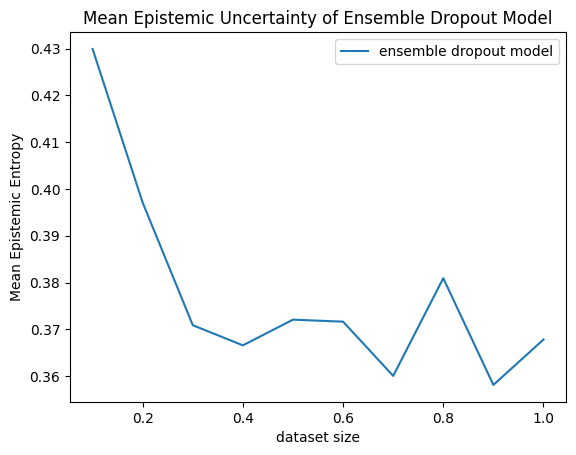

In [152]:
# sketch graph for mean epistemic entropy of ensemble dropout model
plt.plot(dataset_frac, np.mean(epi_entropy_ensemble_dropout, axis=1), label='ensemble dropout model')
plt.xlabel('dataset size')
plt.ylabel('Mean Epistemic Entropy')
plt.title('Mean Epistemic Uncertainty of Ensemble Dropout Model')
plt.legend()
plt.show()


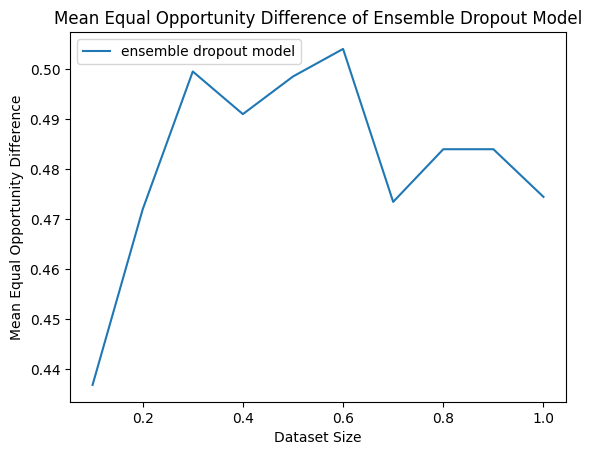

In [153]:
# sketch graph of mean equal opportunity difference for ensemble dropout model
plt.plot(dataset_frac, Equal_opp_diffs_ensemble_dropout, label='ensemble dropout model')
plt.xlabel('Dataset Size')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference of Ensemble Dropout Model')
plt.legend()
plt.show()

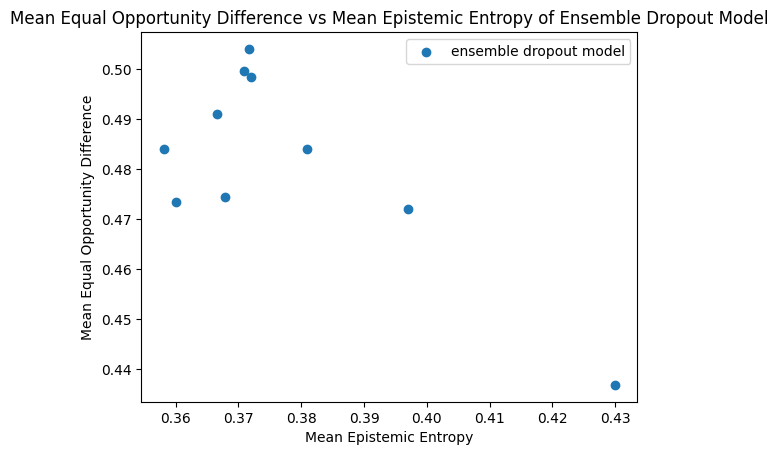

In [154]:
# plot epistemic entropy as x-axis and equal opportunity difference as y-axis for ensemble dropout model
plt.scatter(np.mean(epi_entropy_ensemble_dropout, axis=1), Equal_opp_diffs_ensemble_dropout, label='ensemble dropout model')
plt.xlabel('Mean Epistemic Entropy')
plt.ylabel('Mean Equal Opportunity Difference')
plt.title('Mean Equal Opportunity Difference vs Mean Epistemic Entropy of Ensemble Dropout Model')
plt.legend()
plt.show()

In [27]:
#save to pickle file
import pickle

with open('adult_results/ale_entropy_ensemble_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(ale_entropy_ensemble_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)

with open('adult_results/epi_entropy_ensemble_dropout_dict.pickle', 'wb') as handle:
    pickle.dump(epi_entropy_ensemble_dropout, handle, protocol=pickle.HIGHEST_PROTOCOL)

# #load pickle file
# import pickle

# with open('adult_results/ale_entropy_ensemble_dropout_dict.pickle', 'rb') as handle:
#     ale_entropy_ensemble_dropout = pickle.load(handle)

# with open('adult_results/epi_entropy_ensemble_dropout_dict.pickle', 'rb') as handle:
#     epi_entropy_ensemble_dropout = pickle.load(handle)
